In [1]:
import pandas as pd
import math

/var/folders/70/n0b2gmg91r1_wdwzy0ck2j1h0000gn/T/ipykernel_26961/3795637154.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read original file

In [2]:
# Replace 'your_file.csv' with the path to your CSV file
file_path = './datathon_2024_dataset_corrected.csv'


# Read the CSV file into a pandas DataFrame
original_df = pd.read_csv(file_path)

# Only keep home_team or away_team equals HOU
astro_df = original_df.loc[(original_df['home_team'] == 'HOU') | (original_df['away_team'] == 'HOU')]

print(astro_df.head())

    Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
19          19   20000404       PIT       HOU        False           2   
32          32   20000405       PIT       HOU        False           2   
46          46   20000406       PIT       HOU         True          10   
57          57   20000407       HOU       PHI        False           1   
72          72   20000408       HOU       PHI         True           8   

    away_score  venue            venue_name        city  ... away_hbp  \
19           5  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
32          11  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
46           1  PIT07  Three Rivers Stadium  Pittsburgh  ...        0   
57           4  HOU03      Minute Maid Park     Houston  ...        0   
72           5  HOU03      Minute Maid Park     Houston  ...        1   

    home_pa  home_1b  home_2b  home_3b  home_hr  home_fo  home_so  home_bb  \
19       36        5        0        0

Read location file

In [4]:
location_file_path = './cities_coordinates.xlsx'
location_df = pd.read_excel(location_file_path)
print(location_df.head())

         city  latitude  longitude
0     Atlanta   33.7490   -84.3880
1  Cincinnati   39.1031   -84.5120
2       Miami   25.7617   -80.1918
3    Montreal   45.5017   -73.5673
4    New York   40.7128   -74.0060


Function to calculate the distance with latitudes and longitudes.

In [5]:
# Calculate the distance between two points.

def haversine(lat1, lon1, lat2, lon2):
    # 将经纬度转换为弧度
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine公式
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # 地球半径（单位：公里）
    radius = 6371.0

    # 计算距离
    distance = radius * c

    return distance

# 示例：两个地点的经纬度
lat1, lon1 = 37.7749, -122.4194  # 地点1（例如，旧金山）
lat2, lon2 = 34.0522, -118.2437  # 地点2（例如，洛杉矶）

# 计算距离
result = haversine(lat1, lon1, lat2, lon2)
print(f"distance is：{result:.2f} ")


distance is：559.12 


Delete outlier cities.

In [6]:
#print out all city names

# Delelete all rows with city "Tokyo", "London", "Sydney",  "San Juan", "Monterrey"
astro_df = astro_df[astro_df['city'] != 'Tokyo']
astro_df = astro_df[astro_df['city'] != 'London']
astro_df = astro_df[astro_df['city'] != 'Sydney']
astro_df = astro_df[astro_df['city'] != 'San Juan']
astro_df = astro_df[astro_df['city'] != 'Monterrey']

# print(original_df['city'].unique())

# Count the number of unique city
# print(original_df['city'].nunique())



Add location to original file.

In [7]:
import pandas as pd

# Assuming both venue_name columns are of the same data type


# Merge the two DataFrames based on 'venue_name'
merged_df = pd.merge(astro_df, location_df, on='city', how='inner')

# 'inner' will keep only the rows where venue_name exists in both tables

# Display the merged DataFrame

# Sort merged_df by game_date
merged_df = merged_df.sort_values(by='game_date')
print(merged_df.head(20))



    Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
0           19   20000404       PIT       HOU        False           2   
1           32   20000405       PIT       HOU        False           2   
2           46   20000406       PIT       HOU         True          10   
3           57   20000407       HOU       PHI        False           1   
4           72   20000408       HOU       PHI         True           8   
5           87   20000409       HOU       PHI         True           2   
6           99   20000410       HOU       SLN        False           7   
7          107   20000411       HOU       SLN        False           6   
8          119   20000412       HOU       SLN        False           7   
9          150   20000414       SDN       HOU        False           4   
10         163   20000415       SDN       HOU        False           5   
11         179   20000416       SDN       HOU         True          13   
12         196   20000418       LAN   

Calculate distance from last game.

In [8]:
# Add a column distance to the merged_df. Calculate the distance between the city in this row and the city in last row.
# If the city in this row is the first city, then the distance is 0.
# Use the function haversine() to calculate the distance.
merged_df['distance'] = 0
for i in range(1, len(merged_df)):
    merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merged_df['latitude'].iloc[i], merged_df['longitude'].iloc[i])



/var/folders/70/n0b2gmg91r1_wdwzy0ck2j1h0000gn/T/ipykernel_26961/3300626854.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  merged_df['distance'].iloc[i] = haversine(merged_df['latitude'].iloc[i-1], merged_df['longitude'].iloc[i-1], merg

In [9]:
# change game_date to datetime
merged_df['game_date'] = pd.to_datetime(merged_df['game_date'], format='%Y%m%d')

Modelling distance factor

In [10]:
# Add a column days_after travel
merged_df['days_after_travel'] = 0

# From the second row, if hou_distance equals zero, add one to days_after_travel. If not, set days_after_travel to zero.
for index, row in merged_df.iterrows():
    if index == 0:
        continue
    else:
        if merged_df.loc[index, 'distance'] == 0:
            merged_df.loc[index, 'days_after_travel'] = merged_df.loc[index - 1, 'days_after_travel'] + 1
        else:
            merged_df.loc[index, 'days_after_travel'] = 0

In [85]:
# Use initial_factor * np.exp(-0.5 * days_after_travel) to calculate the fatigue factor
import numpy as np
# The initial factor is distance / 1000 + the fatigue factor in last row
merged_df['distance_factor'] = 0
merged_df['distance_factor'].iloc[0] = merged_df['distance'].iloc[0] / 1000
for index, row in merged_df.iterrows():
    if index == 0:
        continue
    else:
        initial_factor = merged_df.loc[index - 1, 'distance_factor'] + merged_df.loc[index, 'distance'] / 1000
        merged_df.loc[index, 'distance_factor'] = initial_factor * np.exp(-0.1 * merged_df.loc[index, 'days_after_travel'])

print(merged_df[["home_team", "away_team", "distance", "days_after_travel", "distance_factor"]].head(30))

/var/folders/70/n0b2gmg91r1_wdwzy0ck2j1h0000gn/T/ipykernel_26961/3573820665.py:5: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/70/n0b2gmg91r1_wdwzy0ck2j1h0000gn/T/ipykernel_26961/3573820665.py:5: SettingWithCopyWarning:


A val

   home_team away_team     distance  days_after_travel  distance_factor
0        PIT       HOU     0.000000                  0         0.000000
1        PIT       HOU     0.000000                  1         0.000000
2        PIT       HOU     0.000000                  2         0.000000
3        HOU       PHI  1829.889838                  0         1.829890
4        HOU       PHI     0.000000                  1         1.655753
5        HOU       PHI     0.000000                  2         1.355616
6        HOU       SLN     0.000000                  3         1.004265
7        HOU       SLN     0.000000                  4         0.673179
8        HOU       SLN     0.000000                  5         0.408304
9        SDN       HOU  2093.853720                  0         2.502157
10       SDN       HOU     0.000000                  1         2.264046
11       SDN       HOU     0.000000                  2         1.853644
12       LAN       HOU   179.410425                  0         2

In [19]:
# plot a graph showing home_team_distance over time of the team 'HOU'(home_team or away_team)
import matplotlib.pyplot as plt


# Use plotly to plot the graph
import plotly.express as px

fig = px.line(merged_df, x='game_date', y='distance_factor', title='Distance factor for HOU')
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Add rest time and consecutive days of playing

In [86]:
from datetime import timedelta  # Import the timedelta class

# Function to calculate last rest day and consecutive playing days
def calculate_playing_info(team_games):
    sorted_dates = sorted(team_games)
    rest_days = {}
    consecutive_days = {}
    last_date = None
    consecutive_count = 0

    for date in sorted_dates:
        if last_date and date - last_date == timedelta(days=1):
            consecutive_count += 1
        else:
            consecutive_count = 1

        if last_date and date - last_date > timedelta(days=1):
            rest_day = date - timedelta(days=1)
        else:
            rest_day = None

        rest_days[date] = rest_day
        consecutive_days[date] = consecutive_count
        last_date = date

    return rest_days, consecutive_days

# Create a dictionary to store all game dates for each team
team_games = {}
for index, row in merged_df.iterrows():
    for team in [row['home_team'], row['away_team']]:
        if team not in team_games:
            team_games[team] = []
        team_games[team].append(row['game_date'])

# Calculate rest days and consecutive playing days for each team
team_info = {team: calculate_playing_info(dates) for team, dates in team_games.items()}

# Update the DataFrame with the calculated data
for index, row in merged_df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    game_date = row['game_date']

    # Update info for home team
    merged_df.at[index, 'home_last_rest_day'] = team_info[home_team][0].get(game_date)
    merged_df.at[index, 'home_consecutive_playing_days'] = team_info[home_team][1].get(game_date)

    # Update info for away team
    merged_df.at[index, 'away_last_rest_day'] = team_info[away_team][0].get(game_date)
    merged_df.at[index, 'away_consecutive_playing_days'] = team_info[away_team][1].get(game_date)

In [87]:
# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['hou_consecutive_playing_days'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'hou_consecutive_playing_days'] = row['home_consecutive_playing_days']
    else:
        merged_df.loc[index, 'hou_consecutive_playing_days'] = row['away_consecutive_playing_days']



In [88]:
# print only title of table

print(merged_df.columns.values)

['Unnamed: 0' 'game_date' 'home_team' 'away_team' 'is_day_game'
 'home_score' 'away_score' 'venue' 'venue_name' 'city' 'state' 'away_pa'
 'away_1b' 'away_2b' 'away_3b' 'away_hr' 'away_fo' 'away_so' 'away_bb'
 'away_hbp' 'home_pa' 'home_1b' 'home_2b' 'home_3b' 'home_hr' 'home_fo'
 'home_so' 'home_bb' 'home_hbp' 'latitude' 'longitude' 'distance'
 'days_after_travel' 'distance_factor' 'home_last_rest_day'
 'home_consecutive_playing_days' 'away_last_rest_day'
 'away_consecutive_playing_days' 'hou_consecutive_playing_days'
 'home_team_jet_lag' 'away_team_jet_lag' 'hou_jet_lag']


In [89]:
print(merged_df[["game_date", "home_team", "away_team", "hou_consecutive_playing_days"]].head(50))

    game_date home_team away_team  hou_consecutive_playing_days
0  2000-04-04       PIT       HOU                             1
1  2000-04-05       PIT       HOU                             2
2  2000-04-06       PIT       HOU                             3
3  2000-04-07       HOU       PHI                             4
4  2000-04-08       HOU       PHI                             5
5  2000-04-09       HOU       PHI                             6
6  2000-04-10       HOU       SLN                             7
7  2000-04-11       HOU       SLN                             8
8  2000-04-12       HOU       SLN                             9
9  2000-04-14       SDN       HOU                             1
10 2000-04-15       SDN       HOU                             2
11 2000-04-16       SDN       HOU                             3
12 2000-04-18       LAN       HOU                             1
13 2000-04-19       LAN       HOU                             2
14 2000-04-21       HOU       SDN       

Add jet lag

In [90]:
from timezonefinder import TimezoneFinder
import pytz
from datetime import datetime

# Function to get the timezone from latitude and longitude
def get_timezone(latitude, longitude):
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)
    return timezone_str

# Function to calculate the time difference between two timezones
def calculate_time_diff(tz1, tz2):
    if not tz1 or not tz2:
        return 0
    current_time = datetime.utcnow()
    tz1_time = pytz.timezone(tz1).localize(current_time)
    tz2_time = pytz.timezone(tz2).localize(current_time)
    return int((tz1_time.utcoffset() - tz2_time.utcoffset()).total_seconds() / 3600)

# Precompute timezones for each unique location
unique_locations = merged_df[['latitude', 'longitude']].drop_duplicates()
unique_locations['timezone'] = unique_locations.apply(lambda row: get_timezone(row['latitude'], row['longitude']), axis=1)
location_timezones = dict(zip(unique_locations[['latitude', 'longitude']].apply(tuple, axis=1), unique_locations['timezone']))

# Initialize the jet lag columns
merged_df['home_team_jet_lag'] = 0
merged_df['away_team_jet_lag'] = 0

# Dictionary to keep track of the last location of each team
last_locations_timezones = {}

# Iterate through each row in the DataFrame
for index, row in merged_df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    current_location = (row['latitude'], row['longitude'])
    current_timezone = location_timezones[current_location]

    # Calculate jet lag for home team
    if home_team in last_locations_timezones:
        last_timezone = last_locations_timezones[home_team]
        merged_df.at[index, 'home_team_jet_lag'] = calculate_time_diff(current_timezone, last_timezone)
    last_locations_timezones[home_team] = current_timezone

    # Calculate jet lag for away team
    if away_team in last_locations_timezones:
        last_timezone = last_locations_timezones[away_team]
        merged_df.at[index, 'away_team_jet_lag'] = calculate_time_diff(current_timezone, last_timezone)
    last_locations_timezones[away_team] = current_timezone



In [91]:
# Iterate through rows, if HOU is home_team, extract home_consecutive_playing_days, if HOU is away_team, extract away_consecutive_playing_days
# Add all consecutive_playing_days to a column hou_consecutive_playing_days
merged_df['hou_jet_lag'] = 0
for index, row in merged_df.iterrows():
    if row['home_team'] == 'HOU':
        merged_df.loc[index, 'hou_jet_lag'] = row['home_team_jet_lag']
    else:
        merged_df.loc[index, 'hou_jet_lag'] = row['away_team_jet_lag']



In [92]:
# output a csv file
merged_df.to_csv('travel_analysis_astro.csv', index=False)

In [93]:
import pandas as pd

# Replace 'your_file_path.xlsx' with the actual path to your Excel file
file_path = './travel_analysis_astro.csv'

# Load the data
data = pd.read_csv(file_path)

# Multiply the 'distance_factor' column by 1000
data['distance_factor'] = data['distance_factor'] * 1000

# Display the first few rows to verify the changes
print(data[['distance_factor']].head(50))


    distance_factor
0          0.000000
1          0.000000
2          0.000000
3       1829.889838
4       1655.752796
5       1355.615734
6       1004.264836
7        673.178851
8        408.303613
9       2502.157332
10      2264.045580
11      1853.643743
12      2033.054168
13      1839.583484
14      4045.847512
15      3660.834217
16      2997.237555
17      2220.408193
18      1488.384122
19       902.750603
20      2521.622896
21      2281.658750
22      1868.064187
23      1383.895987
24      1514.951591
25      1370.784886
26      1122.303742
27      3926.275249
28      3552.640759
29      2908.656244
30      5114.920272
31      4628.171252
32      3789.226135
33      2807.127763
34      1881.674011
35      1141.292979
36       626.354867
37      2245.227160
38      3417.576337
39      3092.350949
40      2531.802821
41      3704.151998
42      3351.655330
43      4970.527623
44      4497.519381
45      3682.257429
46      2727.883397
47      1828.554924
48      1109.074625


In [72]:
# output a csv file
data.to_csv('travel_analysis_astro.csv', index=False)

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = './travel_analysis_astro.csv'
data = pd.read_csv(file_path)

'''# Create a 'score_diff' column that reflects the margin of victory or defeat for the Houston Astros
data['score_diff'] = data.apply(lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'HOU' else row['away_score'] - row['home_score'], axis=1)


# Fill missing values with zeros
data = data.fillna(0)

# Select features and the target variable
features = ['distance', 'distance_factor', 'hou_consecutive_playing_days']
X = data[features]
y = data['score_diff']'''

# Create a 'home_run' column that reflects the number of home runs for the Houston Astros regardless of being home or away
data['home_run'] = data.apply(lambda row: row['home_hr'] if row['home_team'] == 'HOU' else row['away_hr'], axis=1)

# Fill missing values with zeros
data = data.fillna(0)

# Select features and the target variable
features = ['distance_factor', 'hou_consecutive_playing_days']
X = data[features]
y = data['home_run']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Model coefficients
coefficients = model.coef_

# Output the RMSE and coefficients
rmse, coefficients


(1.1640729780639612, array([-0.01549383, -0.03253423]))

In [95]:
print(data[["home_team", "away_team", "home_run"]])

     home_team away_team  home_run
0          PIT       HOU         1
1          PIT       HOU         1
2          PIT       HOU         0
3          HOU       PHI         1
4          HOU       PHI         2
...        ...       ...       ...
3779       SEA       HOU         0
3780       SEA       HOU         3
3781       ARI       HOU         0
3782       ARI       HOU         0
3783       ARI       HOU         2

[3784 rows x 3 columns]


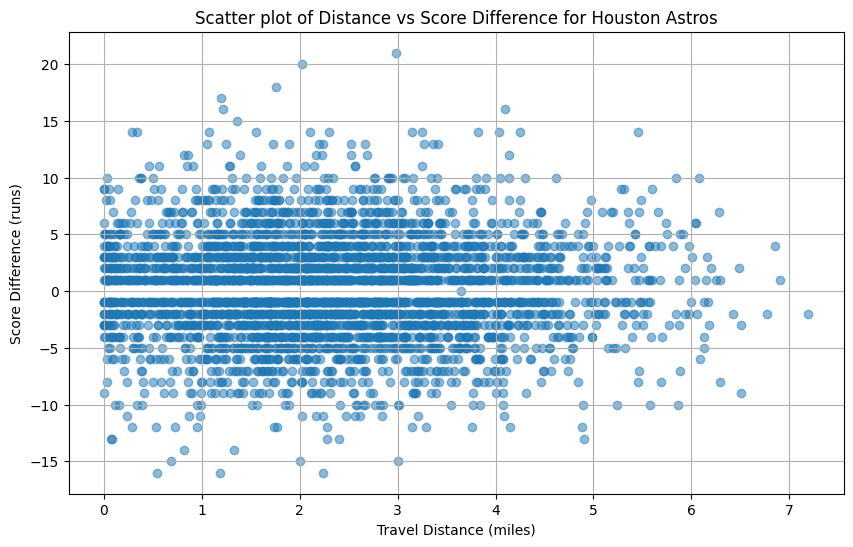

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
file_path = './travel_analysis_astro.csv'
data = pd.read_csv(file_path)

# Create a 'score_diff' column to reflect the margin of victory or defeat for the Houston Astros
data['score_diff'] = data.apply(
    lambda row: row['home_score'] - row['away_score'] if row['home_team'] == 'HOU' else row['away_score'] - row['home_score'],
    axis=1
)

# Plotting scatter points of 'distance' vs. 'score_diff'
plt.figure(figsize=(10, 6))
plt.scatter(data['distance_factor'], data['score_diff'], alpha=0.5)
plt.title('Scatter plot of Distance vs Score Difference for Houston Astros')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Score Difference (runs)')
plt.grid(True)
plt.show()


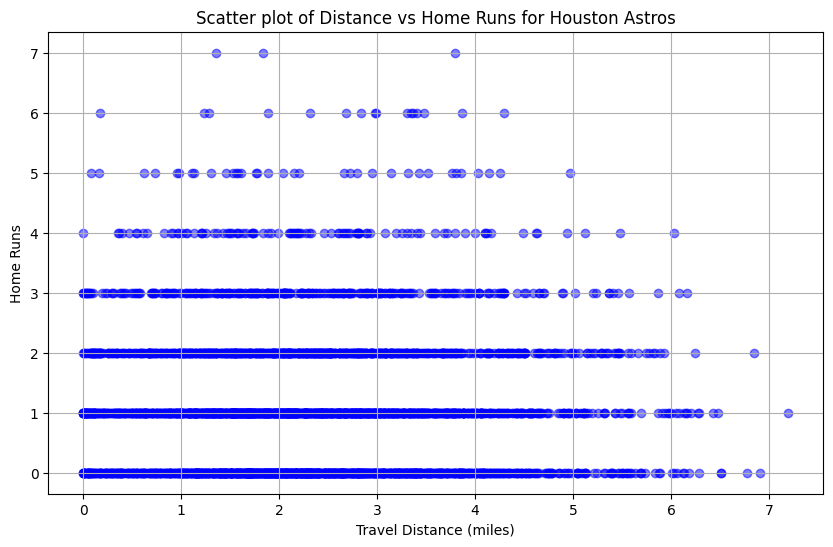

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting scatter points of 'distance' vs. 'home_run'
plt.figure(figsize=(10, 6))
plt.scatter(X['distance_factor'], y, alpha=0.5, color='blue')
plt.title('Scatter plot of Distance vs Home Runs for Houston Astros')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Home Runs')
plt.grid(True)
plt.show()